### Predicting Medical Insurance Claims

New Steps

- One Hot Encoding of categorical predictor variables

-Standardization of continuous output variables

-Neural Nets for regression

-Performance metrics for regression models

-Classic linear regression in sckikit-learn

-The nearest-neighbor predictive model

Previous ideas used again:

-Cross validation to look for evidence of overfitting and estimate expected performance with new data

-Use of permutation methods (ELI5) to understand what the important predictor variables are

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Here is where this data set came from

https://www.kaggle.com/mirichoi0218/insurance?select=insurance.csv

The easiest way to load is typically using pandas,   we can convert values into numpy as necessary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change your infile value

infile="/content/drive/MyDrive/Colab Notebooks/Spring 2024/Machine Learning and Data Mining /Data/insurance.csv"
med_bills=pd.read_csv(infile)

# Just a bit of exploratory analysis so we know what we are dealing with here

Content
Columns

age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance / Number of dependents

smoker: Smoking

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance

In [ ]:
med_bills.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [ ]:
med_bills.shape

(1338, 7)

In [ ]:
#Notice that the categorical variables don't appear in the describe() function

med_bills.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


pandas data frames can be indexed using the iloc method

the loc member function indexes by the column indices (ie column names) and row names


In [ ]:
X=med_bills.iloc[:,0:6]
X.head(3)

,age,sex,bmi,children,smoker,region
0,19,female,27.90,0,yes,southwest
1,18,male,33.77,1,no,southeast
2,28,male,33.00,3,no,southeast


Set up the target or label for the regresion model

In [ ]:
y=med_bills.loc[:,'charges']
y.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

## Encoding the categorical variables

We have 3 columns which are categorical in nature,   sex, smoker, region,   and we need to encode these as one-hot variables

The idea is to:

-extract the categorical columns one a time

-Convert them to numpy form   (pandas.to_numpy)

-Use the sklearn one-hot-encoder

-Convert the data back into pandas data frames,   using the labels from the encoder for the columns

-Concatenate the data frames from the one-hot-encoding back together

I ran into some odd problems with the way the output of the one hot encoder listed the variable names

If you haven't seen Pandas and numpy before,  let me know I can point you to some resources on these.   Numpy is the matrix structure package,   pandas allows for DataFrames like the ones
that appear in R,   or as tables in SSL


What do we have for groups within these categories

In [ ]:
med_bills["sex"].unique()

array(['female', 'male'], dtype=object)

In [ ]:
med_bills["smoker"].unique()

array(['yes', 'no'], dtype=object)

In [ ]:
med_bills["region"].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

# This is a one-hot encoding

We create an instance of a OneHotEncoder and then use it to both fit the data med_bills['sex'] and carry out the one-hot encoding

There are a number of pitfalls in this process, which seems so simple.

First, the encoder will try t use numpy sparse matrix encoding by default,  this is sometimes handy, but it will cause some unexpected results due to the way
the np sparse matrix storage works.  

Set sparse in False when you create the instance of the encoder.

Note:This is also called "dummy" coding the variables.


Note that if we have k categories (or levels or groups),    we could actually use (k-1) columns,  since if the specimen is not in the first (k-1) groups it must be in group k.

I seldom bother to remove the last column, but one could.   Removing it may make it more difficult to see variable interactions using permutation or other methods

In [ ]:
from sklearn.preprocessing import OneHotEncoder

#create an encoder instance

encode_sex=OneHotEncoder(sparse=False)

# extend sex as onehotcolumns.  The conversion to numpy here allows use of the numpy reshape to go to a single complumn variable

mat_sex=encode_sex.fit_transform(med_bills["sex"].to_numpy().reshape(-1,1))





/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# the output here is a numpy matrix
# this uses row and column position indexing

mat_sex[0:5,:]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

We will put this into a pandas dataframe.

The column names are the names used by the encoder,  we can see these by looking at the categories_ in the encoder instance

Here comes a weird and annoying point,   if we look at this variable, it is a list of one list

In [ ]:
encode_sex.categories_


[array(['female', 'male'], dtype=object)]

In [ ]:
type(encode_sex.categories_)

list

In [ ]:
# notice the oddness right here, the length of encode_sex.categories is 1, but we have two labels.   Look close at the categories_ variable, what is it?


len(encode_sex.categories_)

1

In [ ]:
encode_sex.categories_[0][0]

'female'

Why does this matter?   I want to use these titles as the column labels,but if I use a list of list for the columns, we creata a Multiindex,   a new
feature in the pandas dataframes

a Multiindex is a hierarchical column name,   which probably has uses

Watch what happens here if we set the column names to encode_sex.categories_

In [ ]:
df_sex=pd.DataFrame(mat_sex,columns=encode_sex.categories_)

In [ ]:
df_sex.columns

MultiIndex([('female',),
            (  'male',)],
           )

Instead of the column numes being just a list, they are a thing called a Multiindex by setting the column names to a list of lists

We don't want this,  so here's the syntax to get only the first time in the list

In [ ]:
df_sex=pd.DataFrame(mat_sex,columns=encode_sex.categories_[0])

In [ ]:
df_sex.columns

Index(['female', 'male'], dtype='object')

I spent a long time figuring out what was happening here,  really annoying

In [ ]:
# check to see df_sex has what we want
df_sex.head()

,female,male
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [ ]:
encode_smoker=OneHotEncoder()

mat_smoker=encode_smoker.fit_transform(med_bills["smoker"].to_numpy().reshape(-1,1))

df_smoker=pd.DataFrame(mat_smoker.toarray(),columns=encode_smoker.categories_)

In [ ]:
encode_smoker.categories_

[array(['no', 'yes'], dtype=object)]

In [ ]:
# manually set column names,  "no" and "yes" don't mean much,   we want more informative column names
df_smoker.columns=["Non_smoker","Smoker"]

In [ ]:
# just checking!
df_smoker.head()

,Non_smoker,Smoker
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [ ]:
encode_region=OneHotEncoder()

mat_region=encode_region.fit_transform(med_bills["region"].to_numpy().reshape(-1,1))

df_region=pd.DataFrame(mat_region.toarray(),columns=encode_region.categories_[0])

df_region.head()

,northeast,northwest,southeast,southwest
0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0


In [ ]:
df_region.columns

Index(['northeast', 'northwest', 'southeast', 'southwest'], dtype='object')

In [ ]:
# concatenate these one-hot-encoded versions of the categorical variables, and check them

df_cats=pd.concat([df_sex,df_smoker,df_region], axis=1)
df_cats.head()

,female,male,Non_smoker,Smoker,northeast,northwest,southeast,southwest
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df_cats.columns

Index(['female', 'male', 'Non_smoker', 'Smoker', 'northeast', 'northwest',
       'southeast', 'southwest'],
      dtype='object')

It looks like we now have to be a bit careful about this issue of Multiindexes,  this is a new "feature".  

## Standardization

We will standardize the continuous variables within a pipeline.    A pipeline carries out the action requested on each column of the data input

A pipeline can contain many cleaning and formatting operations,  we will both standardize and impute here.  We don't really need to imputer in this case,
the impute was added as an example

In the standard scaler, we will subtract the mean value from each column, and then divide the column by its own standard deviation.

This forces all the variables to be on the same "scale" and keeps them all close to zero where rounding errors are lowest.


In [ ]:
med_bills.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

# pipeline only the continuous data

med_bill_continuous= num_pipeline.fit_transform(med_bills[['age','bmi','children']])

# put the resulting numpy matrix back into a dataframe

med_bill_continuous=pd.DataFrame(med_bill_continuous,columns=['age','bmi','children'])


In [ ]:
# check to be sure this worked right

med_bill_continuous.head()

,age,bmi,children
0,-1.438764,-0.453320,-0.908614
1,-1.509965,0.509621,-0.078767
2,-0.797954,0.383307,1.580926
3,-0.441948,-1.305531,-0.908614
4,-0.513149,-0.292556,-0.908614


In [ ]:
#concatenate with the categorical variables

med_bill_final=pd.concat([med_bill_continuous,df_cats],axis=1)

In [ ]:
med_bill_final.head()

,age,bmi,children,female,male,Non_smoker,Smoker,northeast,northwest,southeast,southwest
0,-1.438764,-0.453320,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-1.509965,0.509621,-0.078767,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.797954,0.383307,1.580926,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.441948,-1.305531,-0.908614,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.513149,-0.292556,-0.908614,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


['age',
 'bmi',
 'children',
 'female',
 'male',
 'Non_smoker',
 'Smoker',
 'northeast',
 'northwest',
 'southeast',
 'southwest']

# test and train split

We have the data set "munged" (formatted really) the way we want it,  scaled and one-hot-encoded,   we can now form the test and train set.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(med_bill_final, y,train_size=0.8,random_state=1)

# Save the data

At this point on a serious project,  I would save the test and train data separately,  and close the file.   I'd start the modeling in a new notebook or file, just to avoid any chance of contaminating
the project wit the test data

I'd also do an exploratory data analysis, to see what is going on in the data set, and only then go on to building predictive models.

To save time, we are just going to dig into the models

-Neural Net regressor

-a linear regression model

-a nearest-neighbor model

# Build the model

In scikit learn,   all models work the same way, in terms of setup

-create a model instance

-fit or train it

-make predictions

The MLPRegressor uses a mean squared error (MSE) criterion for the Loss

We can make use of a variety of performance metrics to understand how the model is doing.   These are resubstitution estimates made on the training data, which tend to be over-optimistic
due to the prevalence of overfitting

In [ ]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(hidden_layer_sizes=(6,3,),random_state=1, max_iter=50000, verbose=False)
regr.fit(X_train, y_train)
y_pred=regr.predict(X_train)

In [ ]:
from sklearn.metrics import explained_variance_score

explained_variance_score(y_train,y_pred)

0.84175188769289

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, y_pred)

23081098.960187037

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_train, y_pred)

0.2882433763829543

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_train, y_pred)

0.8417465281140449

# Try a linear regresion model,   classic least square regression

Again it fits and trains the same way

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train,y_train)
y_pred_lin=reg.predict(X_train)

In [ ]:
explained_variance_score(y_train,y_pred_lin)

0.7477680686451552

# Try nearest neighbor regression

This almost isn't a model,  it simply finds the k specimens closest to a specimens and uses the average value of the k nearest neighbors as the regression value- Note that you can build classifers this
way as well.

The k value used here was 8,   this is a hyperparamenter

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=8)
neigh.fit(X_train, y_train)

y_pred_nn=neigh.predict(X_train)

explained_variance_score(y_train,y_pred_nn)

0.8055459624821658

In [ ]:
y_pred_nn=neigh.predict(X_train)


In [ ]:
r2_score(y_train,y_pred_nn)

0.8031959620565939

## Cross validation

Use cross validation to determine what the expected r2 value would be on new data

An example is shown for the nearest neighbor model

In [ ]:
from sklearn.model_selection import cross_val_score

neigh2 = KNeighborsRegressor(n_neighbors=8)
scores = cross_val_score(neigh2, X_train, y_train, cv=10,scoring='r2')

In [ ]:
np.mean(scores)

0.7229553759141347

In [ ]:
np.std(scores)

0.050203059757298704

# Question:   Use cross validation to examine the performance of the 2 other models,   linear regression and the Neural net.

Which models seem to be overfit?    Can you adjust them slightly to improve performance (don't spend all night on this!)

In [ ]:
# MLPRegressor
# Accuracy of Training Data 0.8417465281140449

y_pred=regr.predict(X_test)
r2_score(y_test, y_pred)

0.8592556942982534

In [ ]:
# LinearRegression
# Accuracy of Training Data 0.7477680686451552

y_pred_lin=reg.predict(X_test)
explained_variance_score(y_test,y_pred_lin)

0.7623598740020211

In [68]:
# KNeighborsRegressor
# Accuracy of Training Data 0.8031959620565939

y_pred_kn=neigh.predict(X_test)
r2_score(y_test,y_pred_kn)

0.7698943502188674

ANSWER:
- This shows that the KNNeighors is more subject to bias and overfitting the data because the Linear regressor model and Neural Network improved but the KNNeighbors decreases with cross validation. We can also see an decrease in the accurcacy of the test data set

##### Can you adjust them slightly to improve performance (don't spend all night on this!)
- No you can't because this will not be a true test of prefromance because your data now is bias now that you tested the accuracy.


# Question: Permutation estimates of variable importance

For each of the three models, use the permutation tools to determine the importance of the different variables.

Can you find strong evidence of interaction of variables?

In [ ]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107717 sha256=11530a385742a862f30433ecebde256681ac281cb1046d45374a4becfb428acb
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [87]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# MLPRegressor

model = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(6,3,),random_state=1, max_iter=50000, verbose=False)
    )
model.fit(X_train,y_train)
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = med_bill_final.columns.tolist())

Weight,Feature
0.4981 ± 0.0210,Smoker
0.4748 ± 0.0472,Non_smoker
0.2432 ± 0.0488,bmi
0.2077 ± 0.0252,age
0.0328 ± 0.0064,northwest
0.0283 ± 0.0083,southwest
0.0221 ± 0.0110,southeast
0.0177 ± 0.0016,male
0.0175 ± 0.0059,northeast
0.0166 ± 0.0040,female


In [83]:
# LinearRegression

perm = PermutationImportance(reg, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = med_bill_final.columns.tolist())

Weight,Feature
0.3185 ± 0.0133,Smoker
0.3155 ± 0.0351,Non_smoker
0.1765 ± 0.0334,age
0.0532 ± 0.0106,bmi
0.0042 ± 0.0016,children
0.0006 ± 0.0009,northeast
0.0006 ± 0.0013,southeast
0.0002 ± 0.0007,southwest
0.0002 ± 0.0004,northwest
0.0001 ± 0.0004,male


In [ ]:
# KNeighborsRegressor
perm = PermutationImportance(neigh, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = med_bill_final.columns.tolist())

Weight,Feature
0.3489 ± 0.0178,Smoker
0.3468 ± 0.0373,Non_smoker
0.1629 ± 0.0268,age
0.1486 ± 0.0427,bmi
0.0321 ± 0.0204,children
-0.0069 ± 0.0108,southeast
-0.0115 ± 0.0064,northwest
-0.0130 ± 0.0080,northeast
-0.0170 ± 0.0051,southwest
-0.0173 ± 0.0059,female


#### **For each of the three models, use the permutation tools to determine the importance of the different variables.**

- The most important variables was Smoker, Non_smoker, Age, and bmi

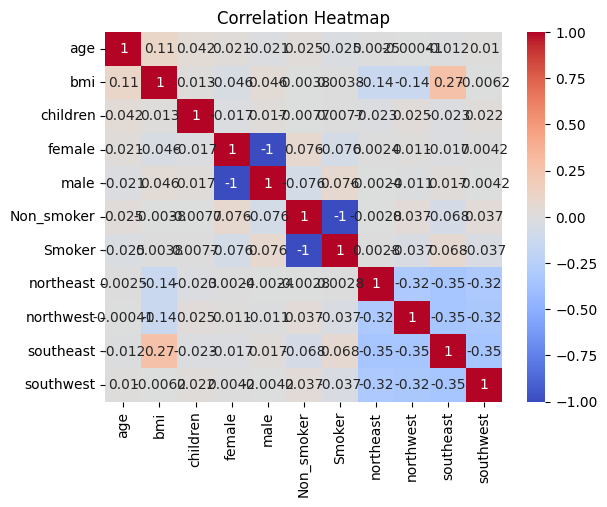

In [90]:
# Calculate correlation matrix
correlation_matrix = med_bill_final.corr()

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

##### **Can you find strong evidence of interaction of variables?**
 - We find strong evidence that smoker and non-smoker are highly correlated because they have a correlation of -1
 - There also appears to be a slight correlation between the locations (northeast, northwest, southeast, southwest)